© Alexander Jüstel, Fraunhofer IEG, Institution for Energy Infrastructures and Geothermal Systems, RWTH Aachen University,
GNU Lesser General Public License v3.0


This notebook was created by Alexander Jüstel and is part of the DGE Rollout Heat Demand Mapping project carried out by students of RWTH Aachen University within the framework of their master thesis. 

# Processing Input Data for DE-NW

This notebook illustrates how to process the data available for DE-NW. In order to reduce file sizes and processing time, only a small part of the available data will be processed (see red outline). If you want to process all of DE-NW replace the input data accordingly. 

The different steps include: 
- Pre-processing of the data
- Calculating the final heat demand

![Input Data DE-NW](../../../images/de_nw_input_data.png)

# Import Libraries 

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

import sys 
sys.path.insert(0, '../../../processing/')

import data_processing

# Pre-Processing of the data

The results of the Pre-Processing include:
- All data reprojected to CRS `EPSG:3034`
- Mask with 10x10 km2 Polyongs covering the input data area
- Average heat demand per square meter of input data

## Import Input Data

The input data will be imported as GeoDataFrame consisting of 100 m x 100 m polygons with the respective heat demand as attribute value. It was extracted from the original input data using QGIS and its intersection function. 

The available file contains the heat demands for both, the residential and commercial sector. The residential heat demand is stored in column `WOHNGEB_WBED` [kWh/a], the commercial heat demand is stored in column `NWOHNGEB_WBED` [kWh/a]. 

In [2]:
input_data = gpd.read_file('../../../data/input_data/de_nw/de_nw_input_data.shp')
input_data.head()

,OBJECTID,CellCode,WOHNGEB_WB,NWOHNGEB_W,AGS,EBZ_WG,EBZ_NWG,RW_WW_p_EB,RW_WW_WBED,Shape_Leng,Shape_Area,geometry
0,1.0,100mN30818E40399,0.000000,0.0,None,0.000000,0.0,0.0,0.000000,400.057890,10002.893659,"POLYGON ((289482.365 5629557.144, 289469.966 5..."
1,2.0,100mN30819E40397,0.000000,0.0,None,0.000000,0.0,0.0,0.000000,400.058293,10002.913797,"POLYGON ((289281.129 5629640.688, 289279.500 5..."
2,3.0,100mN30819E40398,0.000000,0.0,None,0.000000,0.0,0.0,0.000000,400.057989,10002.898592,"POLYGON ((289381.329 5629629.366, 289372.683 5..."
3,4.0,100mN30819E40399,12878.737987,0.0,05334002,90.631513,0.0,142.1,12878.737987,400.057890,10002.893659,"POLYGON ((289456.934 5629588.939, 289456.181 5..."
4,5.0,100mN30820E40396,0.000000,0.0,None,0.000000,0.0,0.0,0.000000,400.058490,10002.923658,"POLYGON ((289179.827 5629732.294, 289178.866 5..."


## Import outline of area

The outline of the area that is evaluated will be loaded as polygon extracted from OpenStreetMaps. 

In [3]:
outline = gpd.read_file('../../../data/outlines/shapes_de_nw/de_nw_aachen_outline.shp').to_crs('EPSG:25832')
outline.head()

,osm_id,class,type,name,address,extratags,geometry
0,62564.0,boundary,administrative,"Aachen, Städteregion Aachen, North Rhine-Westp...","""city""=>""Aachen"",""county""=>""Städteregion Aache...","""ele""=>""173"",""flag""=>""File:Flag de-city of Aac...","POLYGON ((286826.944 5631728.999, 286833.450 5..."


## Correcting for truncated cells

Due to the cropping of the area to a particular region, cells at the edge containing heat demand have been truncated. Hence, we assume that each heat demand (res & com) is reduced by the share of area that is cropped. Hence, we assume that the heat demand is evenly distributed in each cell. This approach may lead to small inaccuracies at the edges. 

The original shape size before cropping is stored in the column `Shape_Area`. The current area can be obtained by the `area` attribute. The calculated `Areal_Share` will then be multiplied by the residential and commercial heat demand. 

![Cropped Shapes along Borders](../../../images/de_nw_borders.png)

In [4]:
input_data['Areal_Share'] = input_data.area/input_data['Shape_Area']
input_data['WOHNGEB_WB'] = input_data['WOHNGEB_WB']*input_data['Areal_Share']
input_data['NWOHNGEB_W'] = input_data['NWOHNGEB_W']*input_data['Areal_Share']

## Plotting the Input Data for residential heat demand

In order to inspect the data, it will be plotted

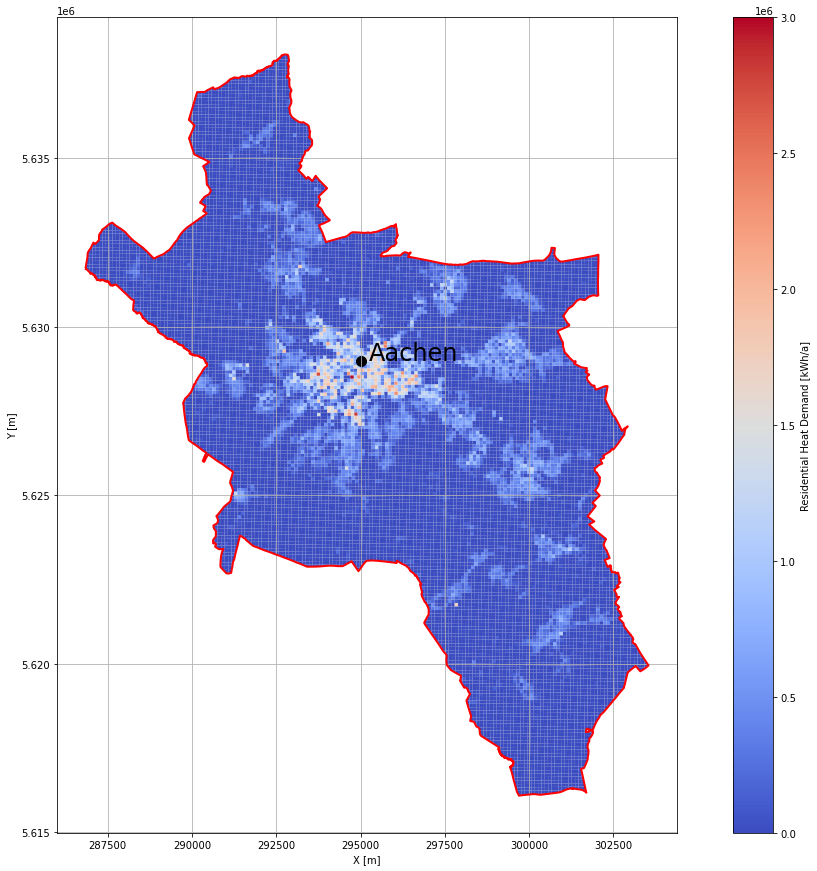

In [5]:
fig, ax = plt.subplots(figsize=(20,15))
outline.boundary.plot(ax=ax, linewidth=2, color='red')
input_data.plot(ax=ax, column='WOHNGEB_WB', legend=True, cmap='coolwarm', vmin = 0, vmax = 3000000, legend_kwds={'label': 'Residential Heat Demand [kWh/a]'})
plt.text(295250, 5.629e6, 'Aachen', size=24, color='black')
plt.scatter(295000, 5.629e6, color='black', s=100)
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.grid()

## Plotting the Input Data for commercial heat demand

In order to inspect the data, it will be plotted

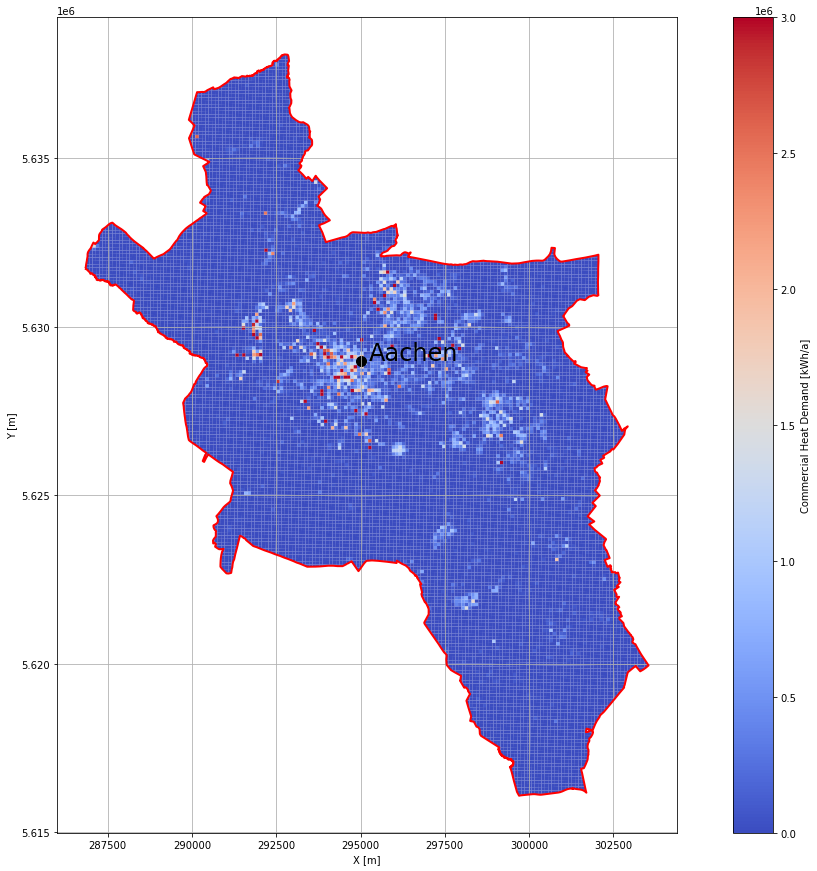

In [6]:
fig, ax = plt.subplots(figsize=(20,15))
outline.boundary.plot(ax=ax, linewidth=2, color='red')
input_data.plot(ax=ax, column='NWOHNGEB_W', legend=True, cmap='coolwarm', vmin = 0, vmax = 3000000, legend_kwds={'label': 'Commercial Heat Demand [kWh/a]'})
plt.text(295250, 5.629e6, 'Aachen', size=24, color='black')
plt.scatter(295000, 5.629e6, color='black', s=100)
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.grid()

## Storing the residential and commercial heat demands in separate GeoDataFrames

The data for the residential and commercial heat demand will be stored in separate GeoDataFrames for further processing.

In [7]:
input_data_HD_res = input_data.copy(deep=True)
input_data_HD_com = input_data.copy(deep=True)

## Reproject data to European CRS

In order to create a harmonized map for Europe, the regional coordinate system of the provided data has to be converted to a European Coordinate System with EPSG code `3034`. 

In [8]:
input_data_HD_res_3034 = input_data_HD_res.to_crs('EPSG:3034')
input_data_HD_com_3034 = input_data_HD_com.to_crs('EPSG:3034')
outline_3034 = outline.to_crs('EPSG:3034')

## Assigning new column provided heat demand

A new column `HD_old` is assigned to each GeoDataFrame to store the provided heat demand data.

In [9]:
input_data_HD_res_3034['HD_old'] = input_data_HD_res_3034['WOHNGEB_WB']
input_data_HD_com_3034['HD_old'] = input_data_HD_com_3034['NWOHNGEB_W']

## Calculating Heat Demand per m2 for each available Polygon

Assuming that the heat demand is evenly distributed within each cell (cropped or not cropped), the head demand per square meter is calculated for each cell.

In [10]:
input_data_HD_res_3034['HD_res_m2'] = input_data_HD_res_3034['HD_old']/input_data_HD_res_3034.area
input_data_HD_com_3034['HD_com_m2'] = input_data_HD_com_3034['HD_old']/input_data_HD_com_3034.area

## Appending the area of the polygon to the GeoDataFrame

In [11]:
input_data_HD_res_3034['area_old'] = input_data_HD_res_3034.area
input_data_HD_com_3034['area_old'] = input_data_HD_com_3034.area

## Filtering cells with no heat demand

The cells that contain no head demand (== 0) are removed.

In [12]:
input_data_HD_res_3034 = input_data_HD_res_3034[input_data_HD_res_3034['HD_res_m2']!=0]
input_data_HD_com_3034 = input_data_HD_com_3034[input_data_HD_com_3034['HD_com_m2']!=0]

## Plotting the filtered data

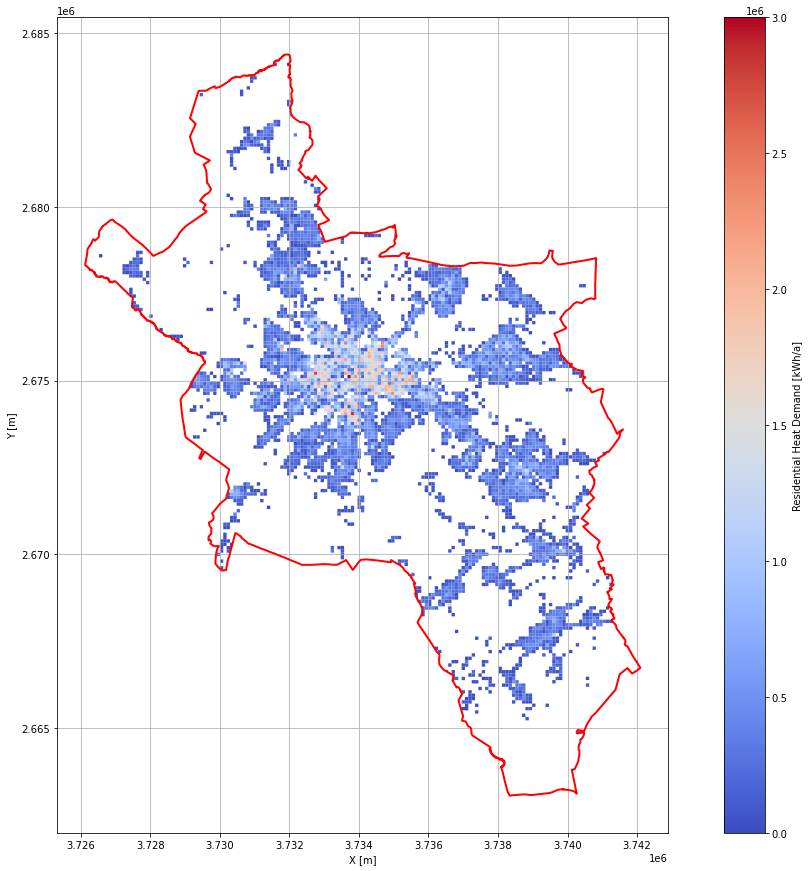

In [13]:
fig, ax = plt.subplots(figsize=(20,15))
outline.to_crs('EPSG:3034').boundary.plot(ax=ax, linewidth=2, color='red')
input_data_HD_res_3034.plot(ax=ax, column='WOHNGEB_WB', legend=True, cmap='coolwarm', vmin = 0, vmax = 3000000, legend_kwds={'label': 'Residential Heat Demand [kWh/a]'})
# plt.text(295250, 5.629e6, 'Aachen', size=24, color='black')
# plt.scatter(295000, 5.629e6, color='black', s=100)
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.grid()

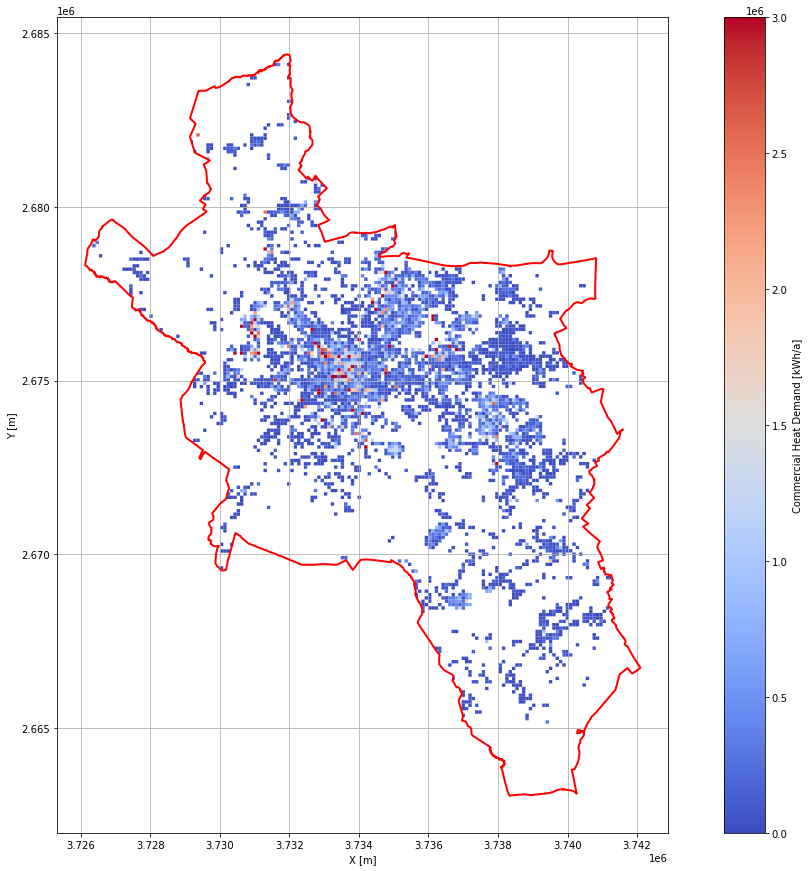

In [14]:
fig, ax = plt.subplots(figsize=(20,15))
outline.to_crs('EPSG:3034').boundary.plot(ax=ax, linewidth=2, color='red')
input_data_HD_com_3034.plot(ax=ax, column= 'NWOHNGEB_W', legend=True, cmap='coolwarm', vmin = 0, vmax = 3000000, legend_kwds={'label': 'Commercial Heat Demand [kWh/a]'})
# plt.text(295250, 5.629e6, 'Aachen', size=24, color='black')
# plt.scatter(295000, 5.629e6, color='black', s=100)
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.grid()

## Loading mask of 10x10 km2 polygons

The final heat demand map covering the entire NWE Region will consist of 100x100 m2 squares. The 10x10 km2 mask to create the smaller squares where already created in a previous notebook.

In [15]:
mask_aachen_10km = gpd.read_file('../../../data/masks/shapes_de_nw/mask_de_nw_aachen_10km.shp').drop('level_0', axis=1)
print(mask_aachen_10km.crs)
mask_aachen_10km

epsg:3034


,index,FID,geometry
0,18197,18197,"POLYGON ((3719984.000 2659951.500, 3719984.000..."
1,18198,18198,"POLYGON ((3719984.000 2669951.500, 3719984.000..."
2,18199,18199,"POLYGON ((3719984.000 2679951.500, 3719984.000..."
3,18365,18365,"POLYGON ((3729984.000 2659951.500, 3729984.000..."
4,18366,18366,"POLYGON ((3729984.000 2669951.500, 3729984.000..."
5,18367,18367,"POLYGON ((3729984.000 2679951.500, 3729984.000..."
6,18533,18533,"POLYGON ((3739984.000 2659951.500, 3739984.000..."
7,18534,18534,"POLYGON ((3739984.000 2669951.500, 3739984.000..."


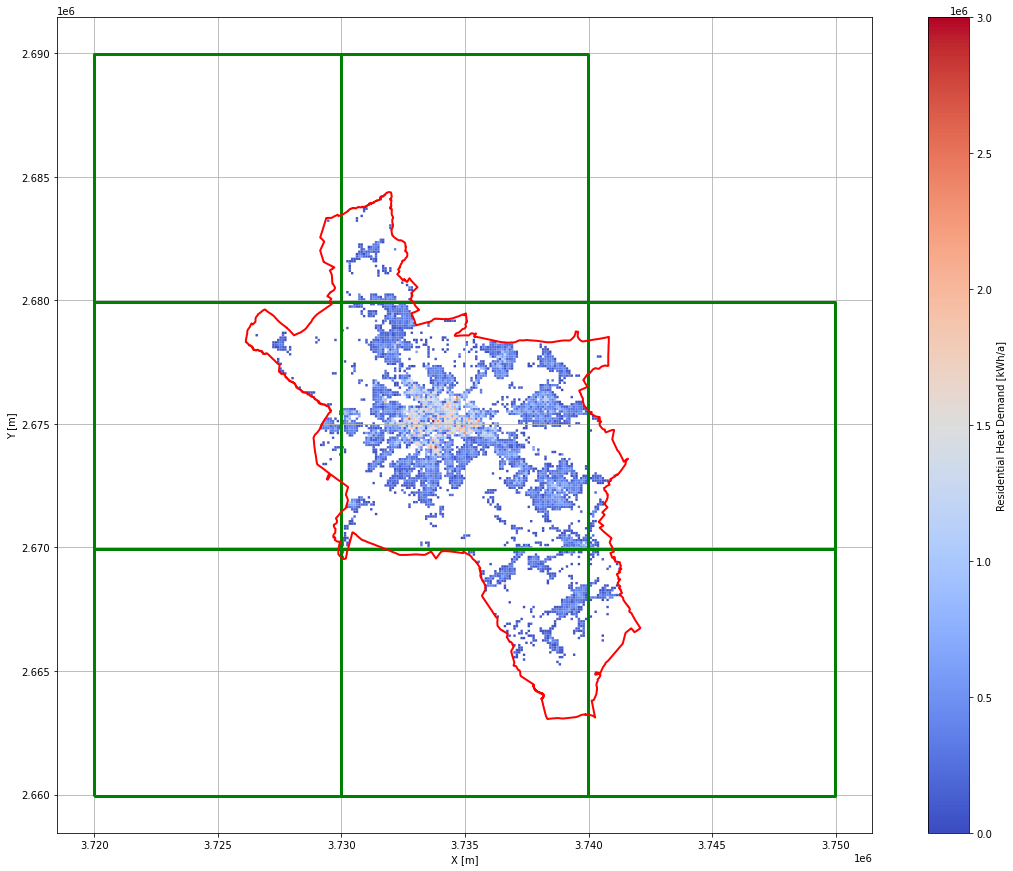

In [16]:
fig, ax = plt.subplots(figsize=(20,15))
mask_aachen_10km.boundary.plot(ax=ax, linewidth=3, color='green')
outline.to_crs('EPSG:3034').boundary.plot(ax=ax, linewidth=2, color='red')
input_data_HD_res_3034.plot(ax=ax, column='WOHNGEB_WB', legend=True, cmap='coolwarm', vmin = 0, vmax = 3000000, legend_kwds={'label': 'Residential Heat Demand [kWh/a]'})
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.grid()

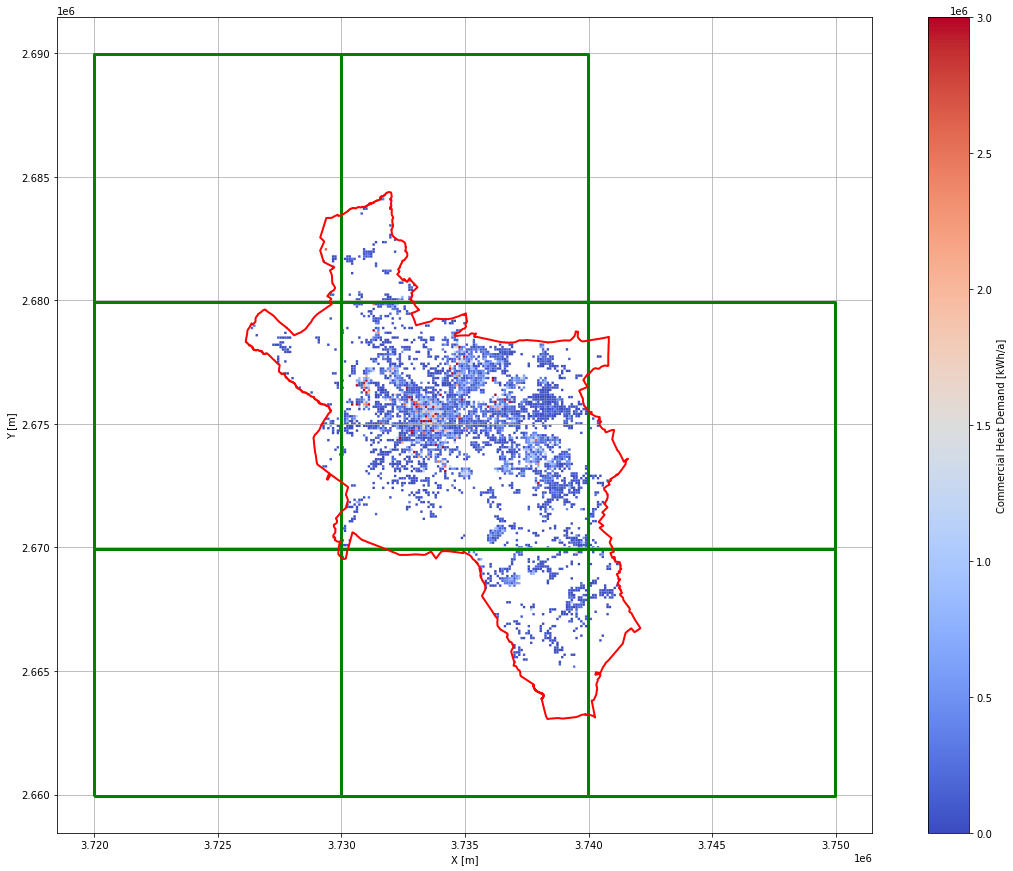

In [17]:
fig, ax = plt.subplots(figsize=(20,15))
mask_aachen_10km.boundary.plot(ax=ax, linewidth=3, color='green')
outline.to_crs('EPSG:3034').boundary.plot(ax=ax, linewidth=2, color='red')
input_data_HD_com_3034.plot(ax=ax, column= 'NWOHNGEB_W', legend=True, cmap='coolwarm', vmin = 0, vmax = 3000000, legend_kwds={'label': 'Commercial Heat Demand [kWh/a]'})
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.grid()

# Calculating the final heat demand

Calculating the final heat demand involves multiple steps after preprocessing the data. The different steps are combined in the function `calculate_hd`:

- Creating 100x100 m2 Polygons for each 10x10 km2 polygon
- Overlaying the input data with each 100x100 m2 mask
- Recalculating the heat demand based on the average heat demand per m2 and the area after the overlay
- Assigning centroids to each new polygon as preparation for the spatial joing
- Intersecting the heat demand data with the 100x100 m2 mask through a spatial join
- Summing up HD values for each 100x100 m2 cell
- Concatenating polygons and mask
- Filling NaN values, removing 0-values, dropping duplicated

In [18]:
hd_res = data_processing.calculate_hd(mask_gdf=mask_aachen_10km,
                                      input_hd_gdf=input_data_HD_res_3034, 
                                      hd_type='res')
hd_res

,HD[MWh/ha],geometry
0,1.163110,"POLYGON ((3729884.000 2669851.500, 3729984.000..."
0,3.394459,"POLYGON ((3726284.000 2678851.500, 3726384.000..."
1,3.186322,"POLYGON ((3726284.000 2678951.500, 3726384.000..."
2,0.947740,"POLYGON ((3726484.000 2678451.500, 3726584.000..."
3,7.104811,"POLYGON ((3726484.000 2678551.500, 3726584.000..."
...,...,...
136,0.305988,"POLYGON ((3740784.000 2672751.500, 3740884.000..."
137,0.994140,"POLYGON ((3740984.000 2672751.500, 3741084.000..."
138,57.737803,"POLYGON ((3740984.000 2672851.500, 3741084.000..."
139,15.701321,"POLYGON ((3741084.000 2672851.500, 3741184.000..."


In [19]:
hd_com = data_processing.calculate_hd(mask_gdf=mask_aachen_10km,
                                      input_hd_gdf=input_data_HD_com_3034,
                                      hd_type='com')
hd_com

,HD[MWh/ha],geometry
0,25.646464,"POLYGON ((3726284.000 2678751.500, 3726384.000..."
1,308.003348,"POLYGON ((3726284.000 2678851.500, 3726384.000..."
2,608.291067,"POLYGON ((3726284.000 2678951.500, 3726384.000..."
3,18.213434,"POLYGON ((3726384.000 2678751.500, 3726484.000..."
4,268.194971,"POLYGON ((3726384.000 2678851.500, 3726484.000..."
...,...,...
110,0.515790,"POLYGON ((3740684.000 2672751.500, 3740784.000..."
111,7.465312,"POLYGON ((3740784.000 2672651.500, 3740884.000..."
112,0.255256,"POLYGON ((3740784.000 2672751.500, 3740884.000..."
113,5.343055,"POLYGON ((3740984.000 2672751.500, 3741084.000..."


# Plotting the final residential and commercial heat demands 

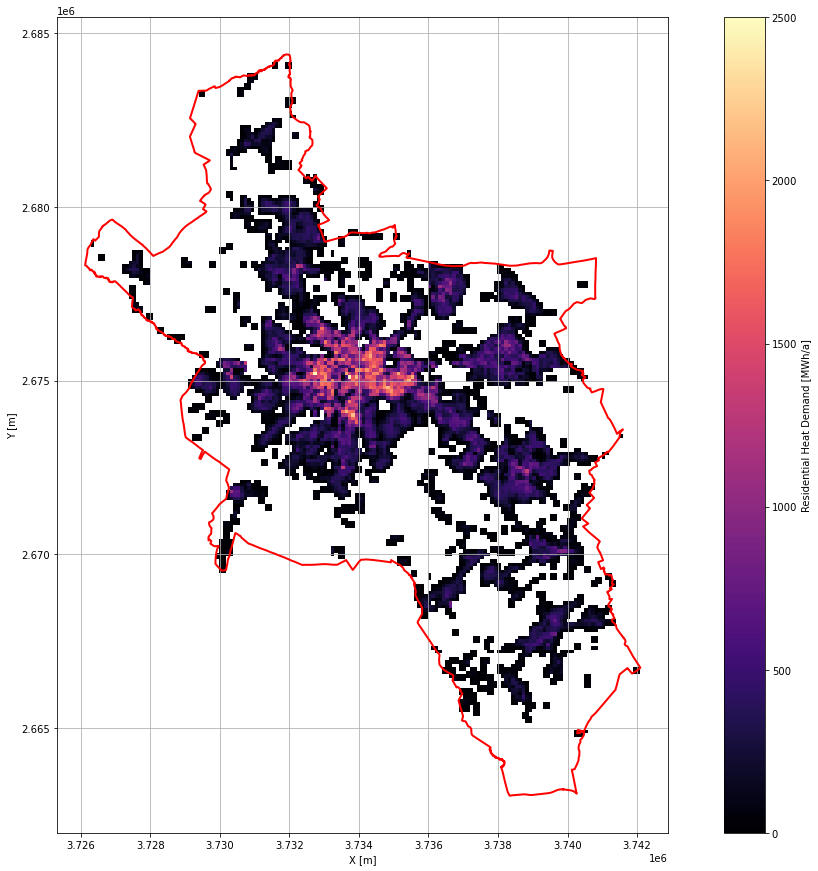

In [20]:
fig, ax = plt.subplots(figsize=(20,15))
outline_3034.boundary.plot(ax=ax, linewidth=2, color='red')
hd_res.plot(ax=ax, linewidth=0.3, column='HD[MWh/ha]', cmap='magma', vmin = 0, vmax = 2500, legend=True, legend_kwds={'label': 'Residential Heat Demand [MWh/a]'})
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.grid()

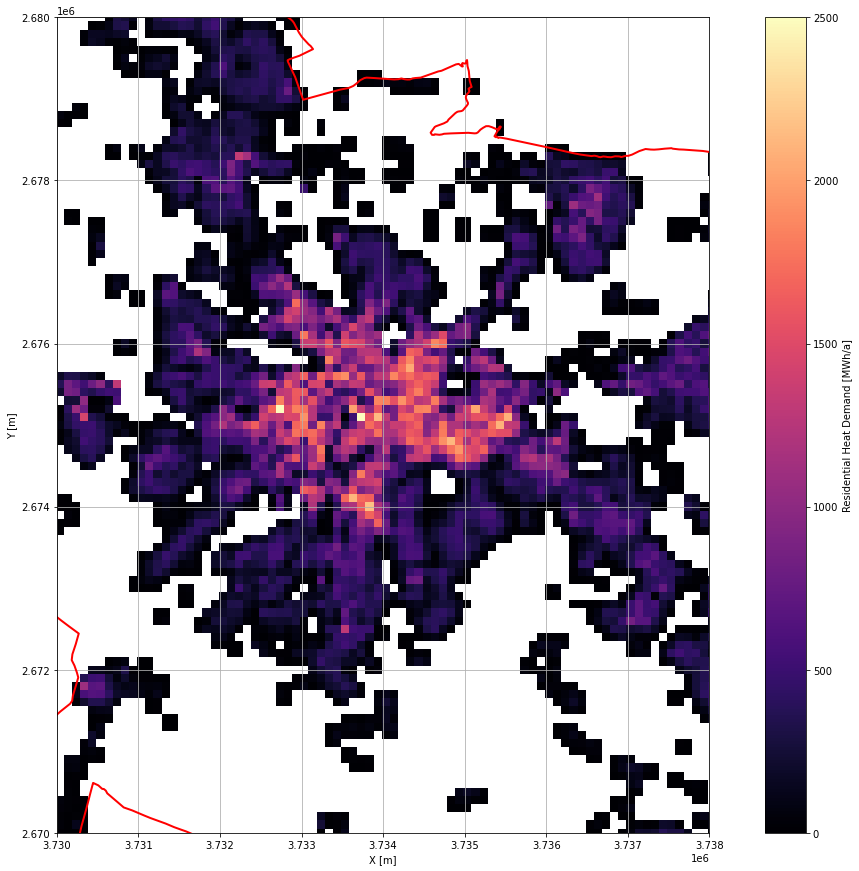

In [21]:
fig, ax = plt.subplots(figsize=(20,15))
outline_3034.boundary.plot(ax=ax, linewidth=2, color='red')
hd_res.plot(ax=ax, linewidth=0.3, column='HD[MWh/ha]', cmap='magma', vmin = 0, vmax = 2500, legend=True, legend_kwds={'label': 'Residential Heat Demand [MWh/a]'})
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.xlim(3.730e6, 3.738e6)
plt.ylim(2.670e6, 2.680e6)
plt.grid()

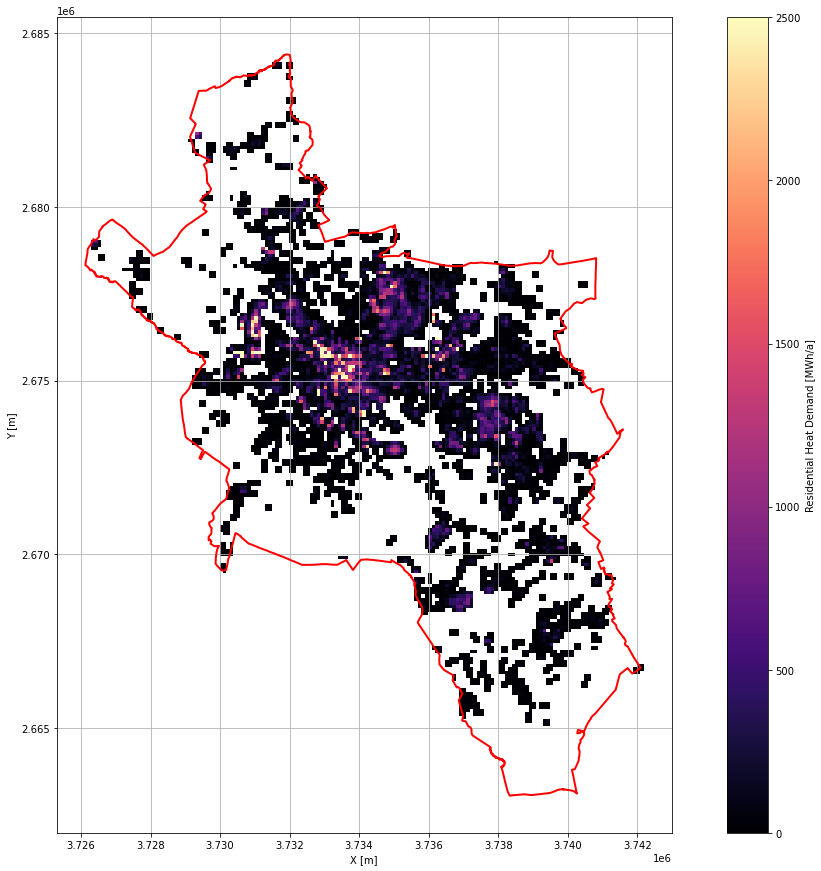

In [22]:
fig, ax = plt.subplots(figsize=(20,15))
outline_3034.boundary.plot(ax=ax, linewidth=2, color='red')
hd_com.plot(ax=ax, linewidth=0.3, column='HD[MWh/ha]', cmap='magma', vmin = 0, vmax = 2500, legend=True, legend_kwds={'label': 'Residential Heat Demand [MWh/a]'})
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.grid()

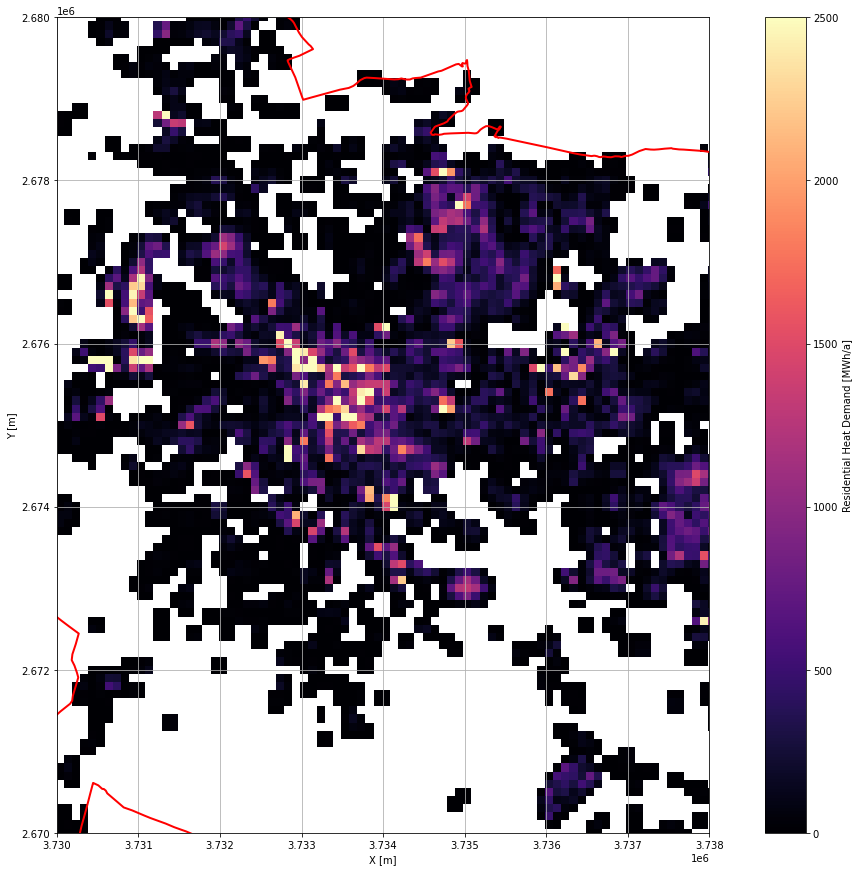

In [23]:
fig, ax = plt.subplots(figsize=(20,15))
outline_3034.boundary.plot(ax=ax, linewidth=2, color='red')
hd_com.plot(ax=ax, linewidth=0.3, column='HD[MWh/ha]', cmap='magma', vmin = 0, vmax = 2500, legend=True, legend_kwds={'label': 'Residential Heat Demand [MWh/a]'})
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.xlim(3.730e6, 3.738e6)
plt.ylim(2.670e6, 2.680e6)
plt.grid()

# Saving Heat Demands as Shape File


In [24]:
hd_res.to_file('../../../data/output_data/de_nw/shapes_de_nw/de_nw_hd_res.shp')
hd_com.to_file('../../../data/output_data/de_nw/shapes_de_nw/de_nw_hd_com.shp')

hd_res.to_crs('EPSG:4326').to_file('../../../data/output_data/de_nw/geojsons_de_nw/de_nw_hd_res.geojson', driver='GeoJSON')
hd_com.to_crs('EPSG:4326').to_file('../../../data/output_data/de_nw/geojsons_de_nw/de_nw_hd_com.geojson', driver='GeoJSON')